In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

In [2]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_test = pd.DataFrame()

# Catboost predictions

In [4]:
fixed_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}
depths = [3,6,8]
l2_leaf_regs = [1.0,3.0,6.0]

In [5]:
def generate_params():
    params = []
    for depth in depths:
        for l2_leaf_reg in l2_leaf_regs:
            param = fixed_params.copy()
            param['depth'] = depth
            param['l2_leaf_reg'] = l2_leaf_reg
            params.append(param)
    return params

def generate_model_name(params,base_name='catboost_base'):
    return f'{base_name}_{params["depth"]}_{params["l2_leaf_reg"]}'

def get_model_predictions(params=fixed_params):
    train_preds = np.zeros(train_df.shape[0])
    test_preds = np.zeros(test_df.shape[0])
    train_class = np.zeros(train_df.shape[0])
    test_class = np.zeros(test_df.shape[0])
    skf = StratifiedKFold(n_splits=3)
    for train_index, test_index in skf.split(train, y):
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
        test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
        model = CatBoostClassifier(**params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=0)
        train_preds[test_index] = model.predict_proba(test_pool)[:,1]
        train_class[test_index] = model.predict(test_pool)
        test_preds += model.predict_proba(submission_pool)[:,1]/3
        test_class = model.predict(submission_pool)
    test_class = np.where(test_class > 2, 1, 0)
    return train_preds,test_preds, train_class, test_class

## Base model

In [6]:
features = [
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
]
cat_features = []
y = train_df['label'].values
train = train_df[features]
test = test_df[features]

submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [7]:
for params in tqdm(generate_params()):
    train_preds, test_preds, train_class, test_class = get_model_predictions(params)
    name = generate_model_name(params)
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds
    model_predictions_train[f'{name}_class'] = train_class
    model_predictions_test[f'{name}_class'] = test_class

100%|██████████| 9/9 [01:03<00:00,  7.06s/it]


## Anomaly based predictions

In [8]:
features = [each for each in train_df.columns if 'anomaly' in each]
cat_features = features[:]
y = train_df['label'].values
train = train_df[features]
test = test_df[features]

submission_pool = Pool(data=test_df[features], cat_features=cat_features)
scale_pos_weight = (y.shape[0]-y.sum())/y.sum()

In [9]:
for params in tqdm(generate_params()):    
    train_preds, test_preds, train_class, test_class = get_model_predictions(params)
    name = generate_model_name(params,'catboost_anomaly')
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds
    model_predictions_train[f'{name}_class'] = train_class
    model_predictions_test[f'{name}_class'] = test_class

100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


# nn predictions

In [10]:
train_df = train_df.fillna(value=0)
test_df = test_df.fillna(value=0)

### autoencoder

In [11]:
features = list(filter(lambda each: ('predicted' not in each) and ('anomaly' not in each) and (each != 'label'), train_df.columns))

X = train_df[features]
Y = train_df['label']

scaler = MinMaxScaler()
x_scale = scaler.fit_transform(X)
x_correct, x_incorrect = x_scale[Y == 1], x_scale[Y == 0]

In [12]:
def get_model():
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    
    return autoencoder

In [13]:
autoencoder = get_model()
autoencoder.fit(x_correct, x_correct, 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20,verbose=False)

In [14]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])


train = hidden_representation.predict(scaler.transform(train_df[features]))
test = hidden_representation.predict(scaler.transform(test_df[features]))
sub_pool = Pool(data=test)

In [18]:
def get_catboost_predictions(params):
    train_preds = np.zeros(train_df.shape[0])
    test_preds = np.zeros(test_df.shape[0])
    train_class = np.zeros(train_df.shape[0])
    test_class = np.zeros(test_df.shape[0])
    skf = StratifiedKFold(n_splits=3)
    for train_index, test_index in skf.split(train, Y):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        train_pool = Pool(data=X_train, label=y_train)
        test_pool = Pool(data=X_test, label=y_test)    
        model = CatBoostClassifier(**params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=0)
        train_preds[test_index] = model.predict_proba(test_pool)[:,1]
        test_preds += model.predict_proba(sub_pool)[:,1]/3
        train_class[test_index] = model.predict(test_pool)
        test_class = model.predict(sub_pool)
    test_class = np.where(test_class > 2, 1, 0)
    return train_preds,test_preds, train_class, test_class

In [19]:
for params in tqdm(generate_params()):
    train_preds, test_preds, train_class, test_class = get_catboost_predictions(params)
    name = generate_model_name(params,'autoencoder_catboost')
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds
    model_predictions_train[f'{name}_class'] = train_class
    model_predictions_test[f'{name}_class'] = test_class

100%|██████████| 9/9 [00:29<00:00,  3.32s/it]


## simple nn

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

callbacks = [early_stopping]

def get_model(input_size,layers=[40,20,10]):
    input_layer = Input(shape=(input_size,))
    
    X = Dense(layers[0],activation='relu')(input_layer)
    for nodes in layers[1:]:
        X = Dense(nodes, activation='relu')(X)
    output_layer = Dense(1, activation='sigmoid')(X)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  metrics=[tfa.metrics.F1Score(num_classes=2,average='micro')])
    return model

#### Without linear predictions

In [21]:
features = list(filter(lambda each: ('predicted' not in each) and ('anomaly' not in each) and (each != 'label'), train_df.columns))

In [22]:
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

In [23]:
folds = 3
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(X_scale, y):
    print('fold:',fold)
    fold += 1
    
    X_train, X_valid = X_scale[train_index], X_scale[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    model = get_model(X_train.shape[1],[100,50,50])
    model.fit(x=X_train,y=y_train,batch_size=512,epochs=100,validation_data=(X_valid,y_valid),callbacks=[callbacks])
    
    y_hat = model.predict(X_valid)
    y_hat = np.where(y_hat > 0.5,1,0)
    score = f1_score(y_valid, y_hat, average='micro')
    
    preds = model.predict(X_test).reshape(test_preds.shape)
    test_preds += preds / 3
    train_preds[test_index] += model.predict(X_valid).reshape(X_valid.shape[0])


fold: 1
Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0434 - f1_score: 0.9529 - val_loss: 0.0403 - val_f1_score: 0.9529
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0404 - f1_score: 0.9529 - val_loss: 0.0401 - val_f1_score: 0.9529
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0397 - f1_score: 0.9529 - val_loss: 0.0396 - val_f1_score: 0.9529
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0390 - f1_score: 0.9529 - val_loss: 0.0386 - val_f1_score: 0.9529
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0379 - f1_score: 0.9529 - val_loss: 0.0382 - val_f1_score: 0.9529
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0368 - f1_score: 0.9529 - val_loss: 0.0375 - val_f1_score: 0.9529
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0356 - f1_score: 0.9529 - val_loss: 0.0357 - val_f1_score: 0.9529
Epoch

Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0365 - f1_score: 0.9529 - val_loss: 0.0385 - val_f1_score: 0.9530
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0356 - f1_score: 0.9529 - val_loss: 0.0389 - val_f1_score: 0.9530
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0345 - f1_score: 0.9529 - val_loss: 0.0367 - val_f1_score: 0.9530
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0335 - f1_score: 0.9529 - val_loss: 0.0391 - val_f1_score: 0.9530
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0334 - f1_score: 0.9529 - val_loss: 0.0342 - val_f1_score: 0.9530
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0319 - f1_score: 0.9529 - val_loss: 0.0335 - val_f1_score: 0.9530
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0313 - f1_score: 0.9529 - val_loss: 0.0337 - val_f1_score: 0.9530
Epoch 12/10

In [24]:
name = 'simple_nn'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

#### with linear predictions

In [25]:
features = list(filter(lambda each: ('anomaly' not in each) and (each != 'label'), train_df.columns))
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

In [26]:
folds = 3
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(X_scale, y):
    print('fold:',fold)
    fold += 1
    
    X_train, X_valid = X_scale[train_index], X_scale[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    model = get_model(X_train.shape[1],[100,50,50])
    model.fit(x=X_train,y=y_train,batch_size=512,epochs=100,validation_data=(X_valid,y_valid),callbacks=[callbacks])
    
    y_hat = model.predict(X_valid)
    y_hat = np.where(y_hat > 0.5,1,0)
    score = f1_score(y_valid, y_hat, average='micro')
    
    preds = model.predict(X_test).reshape(test_preds.shape)
    test_preds += preds / 3
    train_preds[test_index] += model.predict(X_valid).reshape(X_valid.shape[0])


fold: 1
Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0415 - f1_score: 0.9529 - val_loss: 0.0409 - val_f1_score: 0.9529
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0402 - f1_score: 0.9529 - val_loss: 0.0398 - val_f1_score: 0.9529
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0394 - f1_score: 0.9529 - val_loss: 0.0385 - val_f1_score: 0.9529
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0383 - f1_score: 0.9529 - val_loss: 0.0377 - val_f1_score: 0.9529
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0370 - f1_score: 0.9529 - val_loss: 0.0391 - val_f1_score: 0.9529
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0361 - f1_score: 0.9529 - val_loss: 0.0365 - val_f1_score: 0.9529
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0347 - f1_score: 0.9529 - val_loss: 0.0348 - val_f1_score: 0.9529
Epoch

Epoch 25/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0277 - f1_score: 0.9529 - val_loss: 0.0288 - val_f1_score: 0.9530
Epoch 26/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0270 - f1_score: 0.9529 - val_loss: 0.0285 - val_f1_score: 0.9530
Epoch 27/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0272 - f1_score: 0.9529 - val_loss: 0.0290 - val_f1_score: 0.9530
Epoch 28/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0270 - f1_score: 0.9529 - val_loss: 0.0283 - val_f1_score: 0.9530
Epoch 29/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0265 - f1_score: 0.9529 - val_loss: 0.0365 - val_f1_score: 0.9530
Epoch 30/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0279 - f1_score: 0.9529 - val_loss: 0.0286 - val_f1_score: 0.9530
Epoch 31/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0266 - f1_score: 0.9529 - val_loss: 0.0313 - val_f1_score: 0.9530
Epoch 

In [27]:
name = 'simple_nn_with_linear_predictions'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Multihead

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


BATCH_SIZE = 512

STEPS_PER_EPOCH = 3400//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=STEPS_PER_EPOCH*1000,
      decay_rate=1,
      staircase=False)

def get_log_dir(model):
    model_name = '-'.join(map(lambda x: str(x),model))
    return f'./logs/{model_name}'

callbacks = [early_stopping]

def get_combined_model(fare_model, duration_model, meter_waiting_model, meter_waiting_fare_model, model_def=[100,50], freeze_input=True):
    if freeze_input:
        fare_model.trainable = False
        duration_model.trainable = False
        meter_waiting_model.trainable = False
        meter_waiting_fare_model.trainable = False
    
    fare_input = Input(shape=(fare_model.input.shape[1],), name='fare_input')
    fare = fare_model(fare_input)
    
    duration_input = Input(shape=(duration_model.input.shape[1],), name='duration_input')
    duration = fare_model(duration_input)
    
    meter_waiting_input = Input(shape=(meter_waiting_model.input.shape[1],), name='meter_waiting_input')
    meter_waiting = fare_model(meter_waiting_input)
    
    meter_waiting_fare_input = Input(shape=(meter_waiting_fare_model.input.shape[1],), name='meter_waiting_fare_input')
    meter_waiting_fare = fare_model(meter_waiting_fare_input)
    
    X = concatenate([fare,duration,meter_waiting,meter_waiting_fare])
    
    for nodes in model_def:
        X = Dense(nodes, activation='relu')(X)
    output_layer = Dense(1, activation='sigmoid')(X)
    
    model = Model([fare_input,duration_input,meter_waiting_input,meter_waiting_fare_input],output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  metrics=[tfa.metrics.F1Score(num_classes=2,average='micro')])
    return model

In [29]:
fare_representation = tf.keras.models.load_model('models/fare_representation')
duration_representation = tf.keras.models.load_model('models/duration_representation')
meter_waiting_representation = tf.keras.models.load_model('models/meter_waiting_representation')
meter_waiting_fare_representation = tf.keras.models.load_model('models/meter_waiting_fare_representation')

In [30]:
features = [
    'additional_fare', 
    'duration', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference'
]

fare_features = ['additional_fare', 
    'duration', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

duration_features = ['additional_fare', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

meter_waiting_features = ['additional_fare', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'duration',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

meter_waiting_fare_features = ['additional_fare', 
    'meter_waiting',    
    'meter_waiting_till_pickup', 
    'fare',
    'duration',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

In [31]:
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

train = train_df.copy()
train[features] = X_scale

test = test_df.copy()
test[features] = X_test

In [32]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
tf.random.set_seed(0)

folds = 3

model_def=(400, 800, 400, 100, 50, 20, 10)
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(train, y):
    print('fold:',fold)
    fold += 1
    
    X_fare_train, X_fare_test = train[fare_features].iloc[train_index,:],train[fare_features].iloc[test_index,:]
    X_duration_train, X_duration_test = train[duration_features].iloc[train_index,:],train[duration_features].iloc[test_index,:]
    X_meter_waiting_train, X_meter_waiting_test = train[meter_waiting_features].iloc[train_index,:],train[meter_waiting_features].iloc[test_index,:]
    X_meter_waiting_fare_train, X_meter_waiting_fare_test = train[meter_waiting_fare_features].iloc[train_index,:],train[meter_waiting_fare_features].iloc[test_index,:]
    
    y_train, y_valid = y[train_index], y[test_index]
    model = get_combined_model(fare_representation,
                           duration_representation,
                           meter_waiting_representation,
                           meter_waiting_fare_representation,
                           model_def=model_def)
    model.fit({'fare_input':X_fare_train,
              'duration_input':X_duration_train,
              'meter_waiting_input':X_meter_waiting_train,
              'meter_waiting_fare_input':X_meter_waiting_fare_train},
              y_train,
              batch_size=512,
              epochs=500,
              validation_data=({'fare_input':X_fare_test,
              'duration_input':X_duration_test,
              'meter_waiting_input':X_meter_waiting_test,
              'meter_waiting_fare_input':X_meter_waiting_fare_test},y_valid),callbacks=callbacks)
    y_hat = model.predict({'fare_input':X_fare_test,
              'duration_input':X_duration_test,
              'meter_waiting_input':X_meter_waiting_test,
              'meter_waiting_fare_input':X_meter_waiting_fare_test}).reshape(y_valid.shape)
    train_preds[test_index] = y_hat
 
    X_fare, X_duration, X_meter_waiting,X_X_meter_waiting_fare = test[fare_features],test[duration_features],test[meter_waiting_features],test[meter_waiting_fare_features]
    
    preds = model.predict({'fare_input':X_fare,
              'duration_input':X_duration,
              'meter_waiting_input':X_meter_waiting,
              'meter_waiting_fare_input':X_X_meter_waiting_fare}).reshape(test_preds.shape)
    test_preds += preds/3

fold: 1
Epoch 1/500
23/23 [==============================] - 1s 36ms/step - loss: 0.1081 - f1_score: 0.9530 - val_loss: 0.1236 - val_f1_score: 0.9532
Epoch 2/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0592 - f1_score: 0.9530 - val_loss: 0.0579 - val_f1_score: 0.9531
Epoch 3/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0417 - f1_score: 0.9529 - val_loss: 0.0368 - val_f1_score: 0.9529
Epoch 4/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0365 - f1_score: 0.9529 - val_loss: 0.0359 - val_f1_score: 0.9529
Epoch 5/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0353 - f1_score: 0.9529 - val_loss: 0.0346 - val_f1_score: 0.9529
Epoch 6/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0324 - f1_score: 0.9529 - val_loss: 0.0445 - val_f1_score: 0.9529
Epoch 7/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0334 - f1_score: 0.9529 - val_loss: 0.0503 - val_f1_score: 0.952

23/23 [==============================] - 1s 29ms/step - loss: 0.0350 - f1_score: 0.9529 - val_loss: 0.0328 - val_f1_score: 0.9530
Epoch 8/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0320 - f1_score: 0.9529 - val_loss: 0.0315 - val_f1_score: 0.9531
Epoch 9/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0312 - f1_score: 0.9529 - val_loss: 0.0410 - val_f1_score: 0.9531
Epoch 10/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0443 - f1_score: 0.9530 - val_loss: 0.0345 - val_f1_score: 0.9530
Epoch 11/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0314 - f1_score: 0.9529 - val_loss: 0.0313 - val_f1_score: 0.9531
Epoch 12/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0298 - f1_score: 0.9529 - val_loss: 0.0356 - val_f1_score: 0.9531
Epoch 13/500
23/23 [==============================] - 1s 29ms/step - loss: 0.0324 - f1_score: 0.9529 - val_loss: 0.0370 - val_f1_score: 0.9531
Epoch 14/500
2

In [33]:
name = 'multihead_nn'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# LightGBM

In [34]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True


## all features

In [35]:
features = list(filter(lambda each: ('anomaly' not in each) and (each != 'label'), train_df.columns))
train_X = train_df[features]
test_X = test_df[features]
y = train_df['label']

In [36]:
params = {
    'bagging_fraction': 0.7528277381788788,
    'class_weight': None,
    'feature_fraction': 0.5625261317624038,
    'lambda_l2_positive': 0.01363014388342585,
    'learning_rate': 0.11231814419878085,
    'min_child_weight': 20.69211631593017,
    'min_data_in_leaf': 5,
    'num_leaves': 86,
    'subsample_for_bin': 60000
}


In [37]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
test_preds = np.zeros(test_X.shape[0])
train_preds = np.zeros(train_X.shape[0])
for train_index, test_index in skf.split(train_df, y):
    X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test_X) / 3
    train_preds[test_index] = model.predict(X_test)

In [38]:
name = 'lgb_all'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Catboost features

In [39]:
features = [
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
]
train_X = train_df[features]
test_X = test_df[features]

In [40]:
params = {
    'bagging_fraction': 0.9582184397618998,
    'class_weight': 'balanced',
    'feature_fraction': 0.6584730253641345,
    'lambda_l1_positive': 0.004131014051823846,
    'lambda_l2_positive': 2.021463074958273,
    'learning_rate': 0.1292032123987036,
    'min_child_weight': 27.329223863721854,
    'min_data_in_leaf': 3,
    'num_leaves': 120,
    'subsample_for_bin': 20000
}

In [41]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
test_preds = np.zeros(test_X.shape[0])
train_preds = np.zeros(train_X.shape[0])
for train_index, test_index in skf.split(train_df, y):
    X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test_X) / 3
    train_preds[test_index] = model.predict(X_test)

In [42]:
name = 'lgb_catfeatures'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [57]:
features = model_predictions_test.columns
cat_features = [each for each in features if 'class' in each]

for each in cat_features:
    model_predictions_train[each] = model_predictions_train[each].values.astype(int)
    model_predictions_test[each] = model_predictions_test[each].values.astype(int)

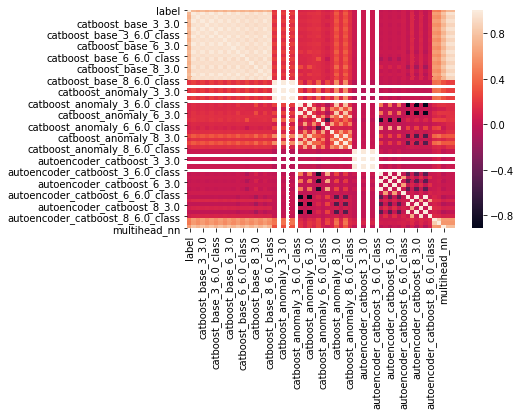

In [58]:
sns.heatmap(model_predictions_train.corr())

In [59]:
model_predictions_train.to_csv('stack_train.csv',index=False)
model_predictions_test.to_csv('stack_test.csv',index=False)

# Catboost stack

In [207]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

ignore = [
    'catboost_base_6_3.0',
    'catboost_base_6_3.0_class',
    'catboost_base_3_6.0',
    'catboost_base_3_6.0_class',
    'catboost_base_3_1.0',
    'catboost_base_3_1.0_class',
    'catboost_base_8_3.0',
    'catboost_base_8_3.0_class',
    'autoencoder_catboost_8_3.0',
    'catboost_anomaly_8_1.0',
    'catboost_anomaly_8_1.0_class',
    
    'catboost_anomaly_3_1.0_class',
    'catboost_anomaly_3_1.0_class',
    'catboost_anomaly_3_3.0_class',
    'catboost_anomaly_3_6.0_class',
    'catboost_anomaly_6_3.0_class',
    'catboost_anomaly_8_3.0_class',
    'catboost_anomaly_8_6.0_class',
    'autoencoder_catboost_3_1.0_class',
    'autoencoder_catboost_3_3.0_class',
    'autoencoder_catboost_3_6.0_class',
    'autoencoder_catboost_6_1.0_class',
#     'autoencoder_catboost_6_3.0_class',
#     'autoencoder_catboost_6_6.0_class',
#     'autoencoder_catboost_8_1.0_class',
#     'autoencoder_catboost_8_6.0_class'
]

features = [each for each in model_predictions_test.columns if each not in ignore]
cat_features = [each for each in features if 'class' in each]

In [208]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [209]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [210]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9752497	test: 0.9765140	best: 0.9765140 (0)	total: 12ms	remaining: 12s
10:	learn: 0.9756683	test: 0.9784408	best: 0.9792811 (6)	total: 68.2ms	remaining: 6.13s
20:	learn: 0.9757902	test: 0.9784200	best: 0.9792811 (6)	total: 131ms	remaining: 6.11s
30:	learn: 0.9759615	test: 0.9784117	best: 0.9792811 (6)	total: 186ms	remaining: 5.82s
40:	learn: 0.9761516	test: 0.9785019	best: 0.9792811 (6)	total: 241ms	remaining: 5.64s
50:	learn: 0.9761493	test: 0.9783951	best: 0.9792811 (6)	total: 291ms	remaining: 5.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9792811024
bestIteration = 6

Shrink model to first 7 iterations.
Validation f1 0.9792811024380843
Learning rate set to 0.057693
0:	learn: 0.9741204	test: 0.9736996	best: 0.9736996 (0)	total: 5.34ms	remaining: 5.33s
10:	learn: 0.9759539	test: 0.9786456	best: 0.9791045 (6)	total: 83.6ms	remaining: 7.51s
20:	learn: 0.9757855	test: 0.9789078	best: 0.9791045 (6)	total: 137ms	remaining

In [211]:
np.mean(validation_scores), np.std(validation_scores)

(0.9773823291441448, 0.0028963763296733737)

In [212]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,catboost_base_6_6.0,19.436296
1,lgb_all,14.748632
2,catboost_base_8_1.0,12.933777
3,lgb_catfeatures,8.067676
4,catboost_base_3_3.0,7.252880
5,catboost_base_6_1.0,6.028625
6,catboost_base_6_1.0_class,5.963208
7,catboost_base_8_6.0,5.353846
8,simple_nn_with_linear_predictions,2.860279
9,catboost_anomaly_6_6.0,2.511490


In [213]:
submission_df['prediction'] = np.where(submission_preds > 0.5, 1, 0)
submission_df.to_csv('submission.csv',index=False)

### Limited features

In [79]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'catboost_anomaly_3_6.0',
    'catboost_base_6_3.0_class',
    'catboost_base_3_1.0_class',
    'autoencoder_catboost_8_1.0_class',
    'catboost_anomaly_3_6.0_class',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn'
]

cat_features = [
    'catboost_base_6_3.0_class',
    'catboost_base_3_1.0_class',
    'autoencoder_catboost_8_1.0_class',
    'catboost_anomaly_3_6.0_class'
]

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [80]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [81]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9746129	test: 0.9771522	best: 0.9771522 (0)	total: 8.93ms	remaining: 8.92s
10:	learn: 0.9757576	test: 0.9781078	best: 0.9781078 (10)	total: 43ms	remaining: 3.86s
20:	learn: 0.9759777	test: 0.9780220	best: 0.9783133 (12)	total: 77ms	remaining: 3.59s
30:	learn: 0.9758301	test: 0.9779192	best: 0.9783133 (12)	total: 111ms	remaining: 3.46s
40:	learn: 0.9760108	test: 0.9773188	best: 0.9783133 (12)	total: 144ms	remaining: 3.38s
50:	learn: 0.9760508	test: 0.9773100	best: 0.9783133 (12)	total: 178ms	remaining: 3.32s
60:	learn: 0.9761378	test: 0.9770093	best: 0.9783133 (12)	total: 217ms	remaining: 3.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.978313253
bestIteration = 12

Shrink model to first 13 iterations.
Validation f1 0.9783132530120483
Learning rate set to 0.057693
0:	learn: 0.9747303	test: 0.9768292	best: 0.9768292 (0)	total: 3.16ms	remaining: 3.16s
10:	learn: 0.9754763	test: 0.9783109	best: 0.9784822 (1)	total: 34.7ms	r

In [82]:
np.mean(validation_scores), np.std(validation_scores)

(0.9768360826471825, 0.0028942093897393662)

In [ ]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

In [ ]:
worst_model = models[np.argmin(validation_scores)]
worst_model.get_feature_importance(prettified=True)

In [ ]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [ ]:
worst_model.plot_tree(0,train_pools[np.argmin(validation_scores)])

In [ ]:
predictions_df = pd.DataFrame()

predictions_df['target'] = labels
predictions_df['worst_model'] = worst_model.predict(train)
predictions_df['best_model'] = best_model.predict(train)

predictions_df['worst_incorrect'] = np.abs(predictions_df['target']-predictions_df['worst_model'])
predictions_df['best_incorrect'] = np.abs(predictions_df['target']-predictions_df['best_model'])

In [ ]:
predictions_df

In [ ]:
predictions_df['worst_incorrect'][:1_000].plot()

In [ ]:
predictions_df['best_incorrect'][:1_000].plot()

In [ ]:
submission_df['prediction'] = np.where(submission_preds > 0.5, 1, 0)
submission_df.to_csv('submission.csv',index=False)

### Meta predictions feature engineerings

All the features

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = list(model_predictions_test.columns)

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

cat_features = []

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [ ]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

limited features

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]
labels = model_predictions_train['label']
model_predictions_train = model_predictions_train[features]
model_predictions_test = model_predictions_test[features]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

cat_features = []

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]

In [ ]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [ ]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

In [ ]:
worst_model = models[np.argmin(validation_scores)]
worst_model.get_feature_importance(prettified=True)

In [ ]:
f_i = best_model.get_feature_importance(prettified=True)
important_features = f_i[f_i['Importances'] > 0]['Feature Id'].values

In [ ]:
model_predictions_train = model_predictions_train[important_features]
model_predictions_test = model_predictions_test[important_features]

submission_pool = Pool(data=model_predictions_test[important_features], cat_features=cat_features)
train = model_predictions_train[important_features]

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

# Extra trees stack

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

In [ ]:
features = model_predictions_test.columns

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [ ]:
params = {
    'n_estimators':10,
    'random_state':0,
    'max_depth':3
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

### Limited features

In [ ]:
features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [ ]:
params = {
    'n_estimators':10,
    'random_state':0,
    'max_depth':3
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

# logistic regression stack

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = model_predictions_test.columns

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [ ]:
params = {    
    'random_state':0,
    'penalty':'l2',
    'solver':'lbfgs',
    'max_iter':1000
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

### Limited features

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [ ]:
params = {    
    'random_state':0,
    'penalty':'l2',
    'solver':'lbfgs',
    'max_iter':1000
}

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]
y = model_predictions_train['label'].values
model_predictions_train = model_predictions_train[features]
model_predictions_test = model_predictions_test[features]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values


In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

In [ ]:
np.mean(validation_scores), np.std(validation_scores)